<a href="https://colab.research.google.com/github/vitalfedorov/ML_Notes/blob/master/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://towardsdatascience.com/implement-gradient-descent-in-python-9b93ed7108d1
# https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a
# http://rstudio-pubs-static.s3.amazonaws.com/303414_fb0a43efb0d7433983fdc9adcf87317f.html
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# https://github.com/scikit-learn/scikit-learn/blob/017000991707d8bf8fafd56207d4aead04cf8834/sklearn/metrics/_ranking.py#L478
# https://stats.stackexchange.com/questions/145566/how-to-calculate-area-under-the-curve-auc-or-the-c-statistic-by-hand


In [0]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn import metrics

import matplotlib.pyplot as plt

In [0]:
rand_state = 115
test_size = 0.4 # just for the demo

In [0]:
data = load_breast_cancer()
train_ds = pd.DataFrame(StandardScaler().fit_transform(data.data), columns = data.feature_names)
targets = data.target

x_train, x_valid, y_train, y_valid = train_test_split(train_ds, targets, test_size = test_size, random_state = rand_state)

lr = LogisticRegression(solver='lbfgs', random_state=rand_state)
m = lr.fit(x_train, y_train)

y_pred = lr.predict(x_valid)
y_pred_proba = lr.predict_proba(x_valid)[:,1]

y_true = y_valid

In [0]:
def calc_tfpn(y_true, y_pred):
  tp = 0 # true positive
  tn = 0 # true negative
  fp = 0 # false positive
  fn = 0 # false negative

  for i in range(len(y_true)):
    if y_true[i] == y_pred[i] == 1:
      tp += 1
    if y_true[i] == y_pred[i] == 0:
      tn += 1
    if y_true[i] == 1 and y_true[i] != y_pred[i]:
      fn += 1
    if y_true[i] == 0 and y_true[i] != y_pred[i]:
      fp += 1  
  return tp, tn, fp, fn

def best_thresold(y_true, y_pred):
  best_thresh = 0
  best_score = 0
  scores = []
  for i in np.arange(0.1, 1.0, 0.01):
    score = f1_score(y_true, np.array(y_pred) > i)
    scores.append(score)
    if score > best_score:
      best_thresh = i
      best_score = score
  return best_thresh, scores

def best_thresold_beta(y_true, y_pred, beta=0.1):
  best_thresh = 0
  best_score = 0
  scores = []
  for i in np.arange(0.1, 1.0, 0.01):
    score = fbeta_score(y_true, np.array(y_pred) > i, beta=beta)
    scores.append(score)
    if score > best_score:
      best_thresh = i
      best_score = score
  return best_thresh, scores

def my_roc_curve(y_true, y_pred):
  desc_score_indices = np.argsort(y_pred, kind="mergesort")[::-1]
  y_pred_desc = y_pred[desc_score_indices]
  y_true_desc = y_true[desc_score_indices]
  distinct_value_indices = np.where(np.diff(y_pred_desc))[0]
  threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

  tps = np.cumsum(y_true_desc * 1)[threshold_idxs]
  fps = 1 + threshold_idxs - tps

  tps = np.r_[0, tps]
  fps = np.r_[0, fps]

  fpr = fps / fps[-1]
  tpr = tps / tps[-1]

  return fpr, tpr, y_pred[threshold_idxs]

### Recall (Sensitivity) or True Positive Rate (TPR)
Recall is a valid choice of evaluation metric when we want to capture as many positives as possible. For example: If we are building a system to predict if a person has cancer or not, we want to capture the disease even if we are not very sure.  

\begin{equation*}
TRP = \frac{TP}{TP + FN}
\end{equation*}

With increase of FN, TRP will decline. If FN=0, TRP=1. We don't care about FP.
### Precision or Positive Predictive Value (PPV)
Precision is a valid choice of evaluation metric when we want to be very sure of our prediction. For example: If we are building a system to predict if we should decrease the credit limit on a particular account, we want to be very sure about our prediction or it may result in customer dissatisfaction. 

\begin{equation*}
PPV = \frac{TP}{TP + FP}
\end{equation*}

With increse of FP, PPV will decline. If FP=0, PPV=1
### Accuracy (ACC)
Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. 

\begin{equation*}
PPV = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation*}

Accuracy simply means the percentage of correct observations.
### F1 score
It’s the harmonic mean between precision and recall.
\begin{equation*}
F_1 = 2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}

### F1 score with Beta
When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose.
\begin{equation*}
F_1 = (1+\beta^2)*\frac{Precision * Recall}{(\beta^2*Precision) + Recall}
\end{equation*}

In [5]:
tp, tn, fp, fn = calc_tfpn(y_true, y_pred)

print('True Positive (TP): {}'.format(tp))
print('True Negative (TN): {}'.format(tn))
print('False Positive (FP): {}'.format(fp))
print('False Negative (FN): {}'.format(fn))

True Positive (TP): 140
True Negative (TN): 82
False Positive (FP): 2
False Negative (FN): 4


In [0]:
# Recall (Sensitivity) or True Positive Rate (TPR)
# TPR = TP / (TP + FN)
tpr = tp / (tp + fn)

# Precision or Positive Predictive Value (PPV)
# PPV = TP / (TP + FP) 
ppv = tp / (tp + fp)

# Specificity or Selectivity or True Negative Rate (TNR)
tnr = tn / (tn + fp)

# Accuracy (ACC)
acc = (tp + tn) / (tp + tn + fp + fn)

# F1 score
f1 = 2 * (ppv * tpr) / (ppv + tpr)

In [7]:
print("Recall (TPR): {:.2f}".format(tpr))
print('Precision (PPV): {:.2f}'.format(ppv))
print('Specificity (TNR): {:.2f}'.format(tnr))
print('Accuracy (ACC): {:.2f}'.format(acc))
print('F1 score (F1): {:.4f}'.format(f1))

Recall (TPR): 0.97
Precision (PPV): 0.99
Specificity (TNR): 0.98
Accuracy (ACC): 0.97
F1 score (F1): 0.9790


In [8]:
f1_score(y_true, y_pred)

0.979020979020979

In [0]:
j, scores = best_thresold(y_true, y_pred_proba)

In [0]:
a = np.arange(0.1, 1.0, 0.01)

Text(0.5, 1.0, 'F1 score')

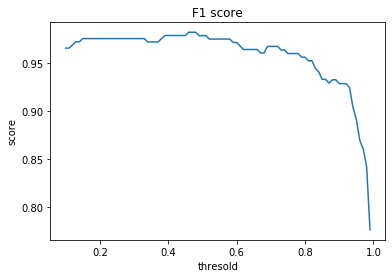

In [46]:
plt.plot(a, scores)
plt.ylabel('score')
plt.xlabel('thresold')
plt.title('F1 score')

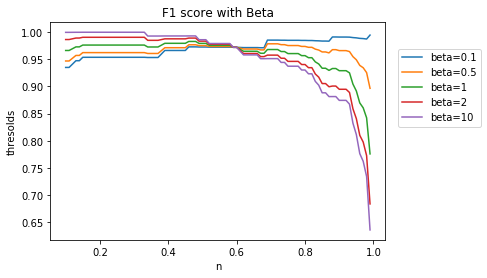

In [53]:
_, scores0 = best_thresold_beta(y_true, y_pred_proba, beta=0.1)
_, scores1 = best_thresold_beta(y_true, y_pred_proba, beta=0.5)
_, scores2 = best_thresold_beta(y_true, y_pred_proba, beta=1)
_, scores3 = best_thresold_beta(y_true, y_pred_proba, beta=2)
_, scores4 = best_thresold_beta(y_true, y_pred_proba, beta=10)

plt.plot(a, scores0, label='beta=0.1')
plt.plot(a, scores1, label='beta=0.5')
plt.plot(a, scores2, label='beta=1')
plt.plot(a, scores3, label='beta=2')
plt.plot(a, scores4, label='beta=10')
plt.ylabel('thresolds')
plt.xlabel('n')
plt.title('F1 score with Beta')
plt.legend(loc="right",  bbox_to_anchor=(1.3, 0.7))

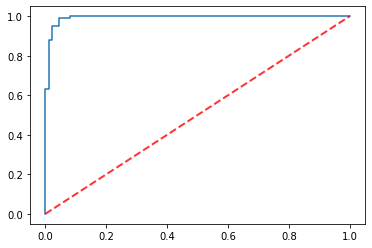

In [11]:
fpr, tpr, thresolds = my_roc_curve(y_true, y_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_proba)

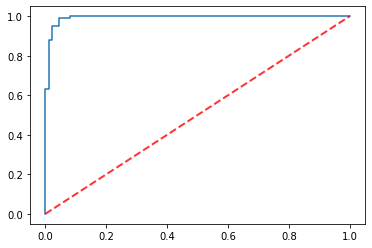

In [13]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

In [58]:
roc_auc_score(y_true, y_pred)

0.969701932525385